In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.metrics import average_precision_score

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_parquet("DATA/train")

In [4]:
LABEL = "fraud"

def evaluate_numeric_feature(df: pd.DataFrame, feature: str) -> pd.Series:
    s = df[feature].astype(float)          # statsmodels/metric 안정화
    y = df[LABEL].astype(int)

    x_nf = s[y == 0]
    x_f  = s[y == 1]

    # KS / MW
    ks_stat, ks_p = ks_2samp(x_nf, x_f)
    mw_stat, mw_p = mannwhitneyu(x_nf, x_f, alternative="two-sided")

    # Cohen's d (pooled std=0 방지)
    nx, nz = len(x_f), len(x_nf)
    sx, sz = x_f.std(), x_nf.std()
    pooled = np.sqrt(((nx - 1) * sx**2 + (nz - 1) * sz**2) / (nx + nz - 2))
    d = np.nan if pooled == 0 or np.isnan(pooled) else (x_f.mean() - x_nf.mean()) / pooled

    # 단변량 PR-AUC (방향성 보정)
    pr_auc = max(
        average_precision_score(y, s),
        average_precision_score(y, -s),
    )

    # 단변량 logit
    odds_ratio = np.nan
    logit_p = np.nan
    try:
        X = sm.add_constant(s.to_frame(name=feature))
        model = sm.Logit(y, X).fit(disp=0)
        odds_ratio = float(np.exp(model.params[feature]))
        logit_p = float(model.pvalues[feature])
    except Exception:
        pass

    return pd.Series({
        "KS_p": float(ks_p),
        "MW_p": float(mw_p),
        "Cohen_d": float(d) if np.isfinite(d) else np.nan,
        "Odds_Ratio": float(odds_ratio) if np.isfinite(odds_ratio) else np.nan,
        "Logit_p": float(logit_p) if np.isfinite(logit_p) else np.nan,
        "PR_AUC": float(pr_auc),
        "n": int(len(s)),
        "pos_rate": float(y.mean()),
    })



EXCLUDE = {"date", "client_id", "card_id", "merchant_id", LABEL}

candidate_features = [
    c for c in df.columns
    if c not in EXCLUDE and pd.api.types.is_numeric_dtype(df[c])
]

rows = []
for f in tqdm(candidate_features, desc="Univariate feature screening"):
    # 상수 컬럼이면 스킵(안정성)
    if df[f].nunique() <= 1:
        continue
    r = evaluate_numeric_feature(df, f)
    r.name = f
    rows.append(r)

res = pd.DataFrame(rows)
res.index.name = "feature"

res_sorted = res.sort_values("PR_AUC", ascending=False)

Univariate feature screening:   0%|          | 0/55 [00:00<?, ?it/s]

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
res_sorted.to_csv("artifacts/univariate_screening_train.csv", encoding="utf-8-sig")

In [6]:
res_sorted

,KS_p,MW_p,Cohen_d,Odds_Ratio,Logit_p,PR_AUC,n,pos_rate
feature,,,,,,,,
mccg_Industrial_/_Manufacturing,3.773248e-63,0.000000e+00,3.293001,NaN,NaN,0.114718,609655.0,0.010823
amount_income_ratio,0.000000e+00,0.000000e+00,0.245297,1.039845e+00,4.200211e-18,0.034765,609655.0,0.010823
log_abs_amount,0.000000e+00,0.000000e+00,0.647072,1.905734e+00,0.000000e+00,0.034671,609655.0,0.010823
amount,0.000000e+00,0.000000e+00,0.657115,1.002283e+00,0.000000e+00,0.030839,609655.0,0.010823
amount_limit_ratio,0.000000e+00,6.891895e-251,0.104653,1.000000e+00,1.189246e-05,0.028809,609655.0,0.010823
mccg_Retail,8.023514e-150,0.000000e+00,1.206827,1.268877e+01,0.000000e+00,0.027459,609655.0,0.010823
mccg_Food_Daily,0.000000e+00,0.000000e+00,1.088365,7.054591e+00,0.000000e+00,0.025363,609655.0,0.010823
mccg_Transport_Travel,0.000000e+00,0.000000e+00,-1.108233,7.019452e-02,0.000000e+00,0.024655,609655.0,0.010823
tx_year,1.563508e-242,1.871666e-09,-0.093446,9.467382e-01,4.625980e-14,0.015941,609655.0,0.010823


In [7]:
df.shape

(609655, 60)

### Logit_p 기준 filtering

In [8]:
alpha = 0.05

sig = res_sorted[
    (res_sorted["Logit_p"] < alpha) &
    (res_sorted["KS_p"] < alpha) &
    (res_sorted["MW_p"] < alpha)
].copy()

sig_feature_names = sig.index.tolist()
print(f"kept_features = {len(sig_feature_names)}")

kept_features = 34


In [9]:
sig_feature_names

['amount_income_ratio',
 'log_abs_amount',
 'amount',
 'amount_limit_ratio',
 'mccg_Retail',
 'mccg_Food_Daily',
 'mccg_Transport_Travel',
 'tx_year',
 'per_capita_income',
 'is_refund',
 'yearly_income',
 'log_yearly_income',
 'credit_limit',
 'mccg_Financial',
 'income_ratio_region',
 'log_income_ratio_region',
 'tx_hour',
 'num_credit_cards',
 'total_debt',
 'years_to_retirement',
 'year_pin_last_changed',
 'tx_month',
 'current_age',
 'is_prepaid',
 'mccg_Digital_Online',
 'is_weekend',
 'mccg_Utilities_Government',
 'tx_day',
 'mccg_Automotive_Home',
 'has_error',
 'months_from_account',
 'cb_Visa',
 'has_chip',
 'credit_score']

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 609655 entries, 5 to 5332941
Data columns (total 60 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             609655 non-null  datetime64[ns]
 1   client_id                        609655 non-null  int64         
 2   card_id                          609655 non-null  int64         
 3   amount                           609655 non-null  float32       
 4   merchant_id                      609655 non-null  int64         
 5   current_age                      609655 non-null  int64         
 6   per_capita_income                609655 non-null  float32       
 7   yearly_income                    609655 non-null  float32       
 8   total_debt                       609655 non-null  float32       
 9   credit_score                     609655 non-null  int64         
 10  num_credit_cards                 609655 non-null

---

## 0) 식별자/메타 컬럼 (분석은 ‘분리/집계’ 목적, 모델엔 보통 제외)

* `date` : 시계열 분포/드리프트/계절성 확인용 (모델 입력은 보통 time feature로만)
* `client_id` : 고객 단위 집계 피처 만들 때 키
* `card_id` : 카드 단위 집계/행동 피처 만들 때 키
* `merchant_id` : 가맹점 단위 집계/위험도 피처 만들 때 키

**분석 포인트**

* 키별 거래수 분포(heavy user / heavy merchant)
* fraud가 특정 key에 몰리는지(집중도)
* key별 “과거 이력 기반” 피처 만들 여지
---

In [11]:
LABEL = "fraud"

### 1️⃣ date — 시계열 분포 & fraud drift

1-1) 월별 거래 수

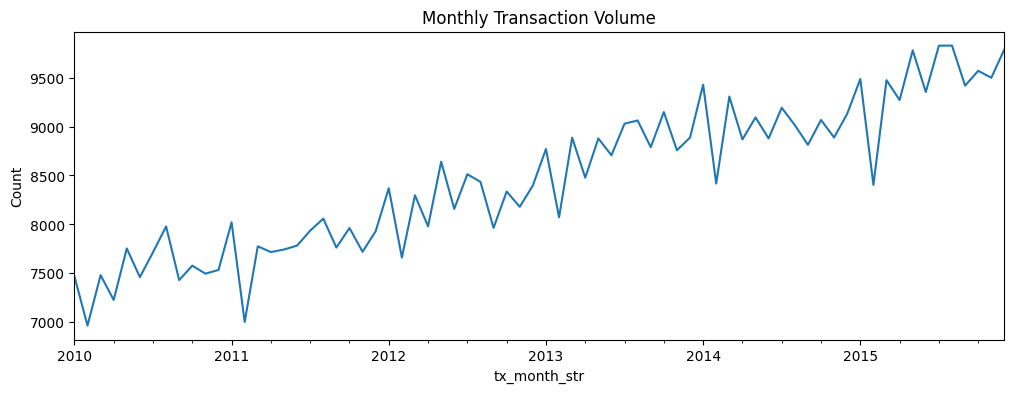

In [12]:
monthly_tx = (
    df
    .assign(tx_month_str=df["date"].dt.to_period("M"))
    .groupby("tx_month_str")
    .size()
)

plt.figure(figsize=(12,4))
monthly_tx.plot()
plt.title("Monthly Transaction Volume")
plt.ylabel("Count")
plt.show()

1-2) 월별 fraud rate

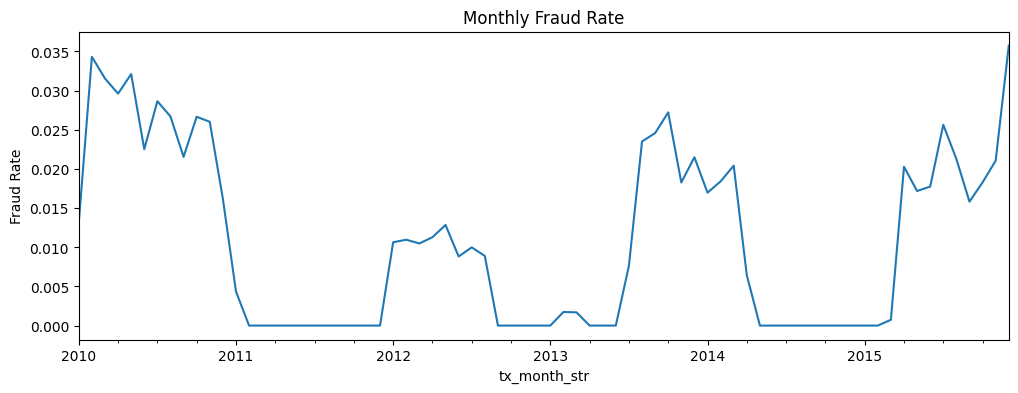

In [13]:
monthly_fraud = (
    df
    .assign(tx_month_str=df["date"].dt.to_period("M"))
    .groupby("tx_month_str")[LABEL]
    .mean()
)

plt.figure(figsize=(12,4))
monthly_fraud.plot()
plt.title("Monthly Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()


### 2️⃣ client_id — 고객 단위 분석

2-1) 고객별 거래 수 분포

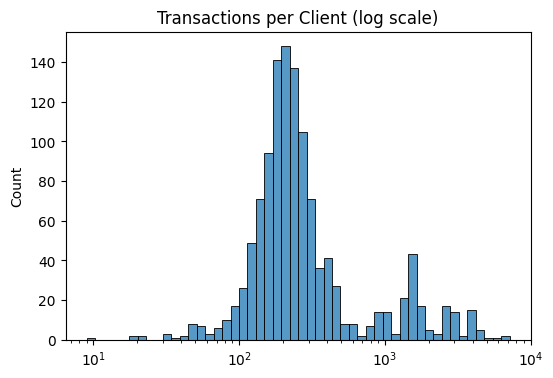

In [14]:
client_tx_count = df.groupby("client_id").size()

plt.figure(figsize=(6,4))
sns.histplot(client_tx_count, bins=50, log_scale=True)
plt.title("Transactions per Client (log scale)")
plt.show()

2-2) 고객별 fraud rate

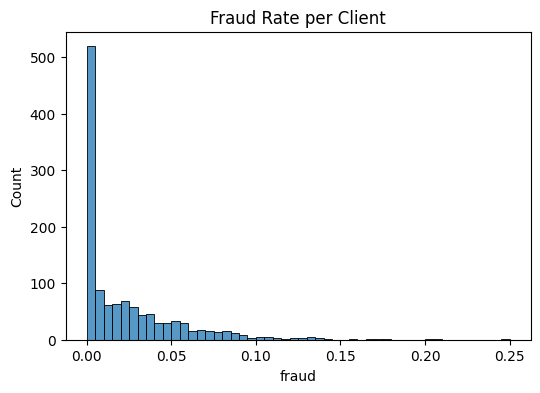

In [15]:
client_fraud_rate = df.groupby("client_id")[LABEL].mean()

plt.figure(figsize=(6,4))
sns.histplot(client_fraud_rate, bins=50)
plt.title("Fraud Rate per Client")
plt.show()

2-3) fraud 집중도 (상위 고객 비율)

In [16]:
client_fraud_sum = df.groupby("client_id")[LABEL].sum()
top_clients = client_fraud_sum.sort_values(ascending=False)

top_10_ratio = top_clients.head(10).sum() / df[LABEL].sum()

print("Top 10 clients fraud concentration:", top_10_ratio)


Top 10 clients fraud concentration: 0.047135495604728704


### 3️⃣ card_id 분석

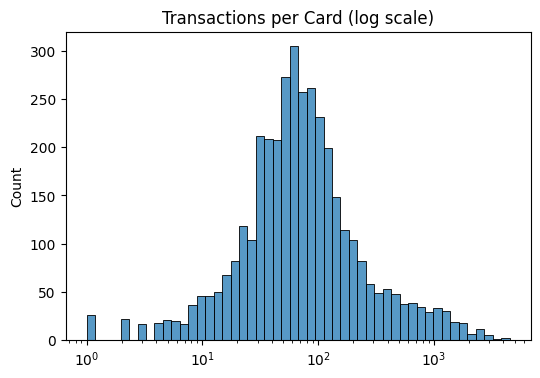

In [17]:
card_tx_count = df.groupby("card_id").size()

plt.figure(figsize=(6,4))
sns.histplot(card_tx_count, bins=50, log_scale=True)
plt.title("Transactions per Card (log scale)")
plt.show()

카드별 fraud rate

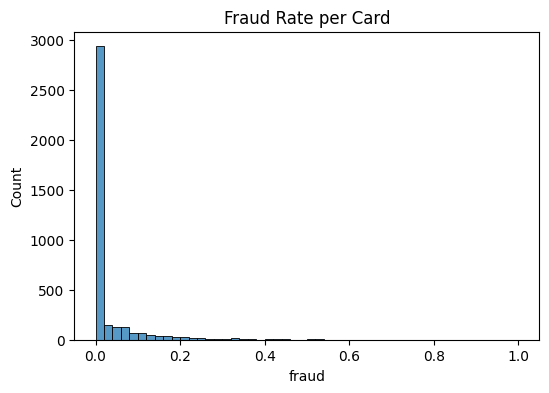

In [18]:
card_fraud_rate = df.groupby("card_id")[LABEL].mean()

plt.figure(figsize=(6,4))
sns.histplot(card_fraud_rate, bins=50)
plt.title("Fraud Rate per Card")
plt.show()


### 4️⃣ merchant_id — 가맹점 위험도

4-1) 가맹점별 거래 수

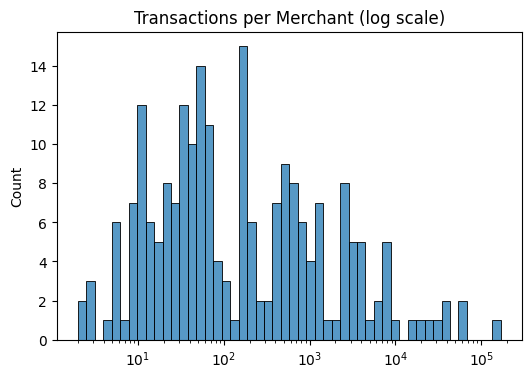

In [19]:
merchant_tx = df.groupby("merchant_id").size()

plt.figure(figsize=(6,4))
sns.histplot(merchant_tx, bins=50, log_scale=True)
plt.title("Transactions per Merchant (log scale)")
plt.show()


4-2) 가맹점별 fraud rate

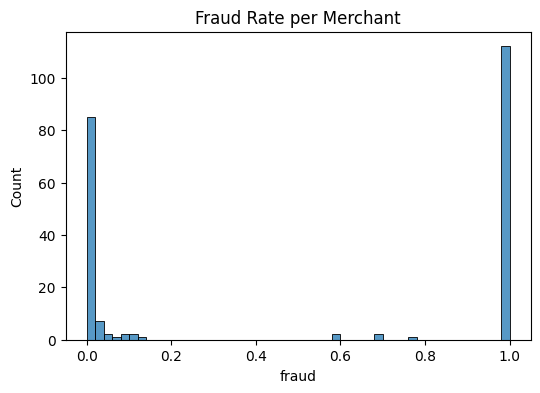

In [20]:
merchant_fraud = df.groupby("merchant_id")[LABEL].mean()

plt.figure(figsize=(6,4))
sns.histplot(merchant_fraud, bins=50)
plt.title("Fraud Rate per Merchant")
plt.show()

4-3) fraud 집중도 (상위 가맹점)

In [21]:
merchant_fraud_sum = df.groupby("merchant_id")[LABEL].sum()
top_merchants = merchant_fraud_sum.sort_values(ascending=False)

top_10_ratio = top_merchants.head(10).sum() / df[LABEL].sum()

print("Top 10 merchants fraud concentration:", top_10_ratio)

Top 10 merchants fraud concentration: 0.3258563200969991


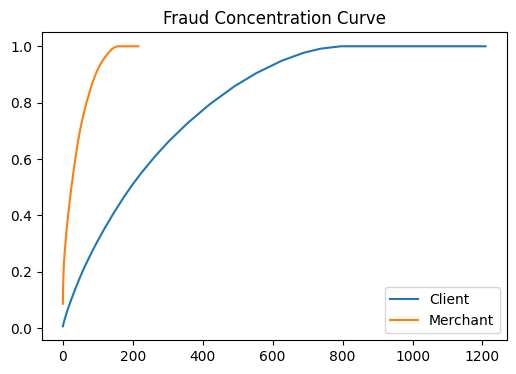

In [22]:
def concentration_ratio(group_sum):
    total = group_sum.sum()
    sorted_vals = group_sum.sort_values(ascending=False)
    cum = sorted_vals.cumsum() / total
    return cum

client_conc = concentration_ratio(client_fraud_sum)
merchant_conc = concentration_ratio(merchant_fraud_sum)

plt.figure(figsize=(6,4))
plt.plot(client_conc.values, label="Client")
plt.plot(merchant_conc.values, label="Merchant")
plt.legend()
plt.title("Fraud Concentration Curve")
plt.show()


### 📊 ID / Meta Column Structural Analysis Summary
1️⃣ Transaction Volume Trend

> 월별 거래량은 전반적으로 지속적인 증가 추세를 보임.\
> 따라서 fraud 건수 자체보다는 fraud rate 기준으로 판단해야 함.\
> 운영 단계에서는 거래량 증가에 따른 threshold 조정 전략이 필요함.

2️⃣ Fraud Rate Seasonality

> 월별 fraud rate는 약 1년 주기의 상승·하락 패턴을 보임.\
> 완전한 랜덤이 아니라 주기적/파동형 구조 존재.\
> 시간 변수는 구조적으로 의미 있는 설명 변수일 가능성이 높음.

3️⃣ Client-Level Pattern

> 대부분의 고객은 fraud가 없음.\
> 일부 고객에서 fraud가 반복적으로 발생.\
> 고객 단위의 이력 기반 리스크 효과가 존재함.\
> 과거 fraud 경험 여부, 누적 fraud 횟수 등은 유의미한 피처가 될 가능성 높음.

4️⃣ Card-Level Pattern

> 카드 단위 반복 fraud는 상대적으로 많지 않음.\
> 카드 레벨 이력 효과는 client 레벨보다 약함.

5️⃣ Merchant-Level Concentration

> fraud가 특정 merchant에 강하게 집중되어 있음.\
> 일부 merchant는 매우 높은 fraud rate를 보임.\
> 구조적 리스크가 merchant 단위에서 발생하는 패턴.\
> merchant risk score 또는 blacklist 관리가 필요할 가능성 높음.

In [23]:
df = df.sort_values("date").copy()

g_client = df.groupby("client_id")["fraud"]
df["client_prev_fraud_cnt"] = (g_client.cumsum() - df["fraud"]).astype("int32")

g_merchant = df.groupby("merchant_id")["fraud"]
df["merchant_prev_fraud_cnt"] = (g_merchant.cumsum() - df["fraud"]).astype("int32")

# 검증: 첫 거래는 무조건 0
print((df.groupby("client_id")["client_prev_fraud_cnt"].head(1) != 0).sum())
print((df.groupby("merchant_id")["merchant_prev_fraud_cnt"].head(1) != 0).sum())

0
0


In [24]:
df["month_sin"] = np.sin(2 * np.pi * df["tx_month"] / 12).astype("float32")
df["month_cos"] = np.cos(2 * np.pi * df["tx_month"] / 12).astype("float32")

In [25]:
df["day_sin"] = np.sin(2 * np.pi * df["tx_day"] / 31).astype("float32")
df["day_cos"] = np.cos(2 * np.pi * df["tx_day"] / 31).astype("float32")

In [26]:
df["hour_sin"] = np.sin(2 * np.pi * df["tx_hour"] / 24).astype("float32")
df["hour_cos"] = np.cos(2 * np.pi * df["tx_hour"] / 24).astype("float32")

In [27]:
cyc_features = [
    "month_sin", "month_cos",
    "day_sin", "day_cos",
    "hour_sin", "hour_cos"
]

for col in cyc_features:
    print(col)
    print(evaluate_numeric_feature(df, col))


month_sin
KS_p          2.809612e-18
MW_p          2.901159e-08
Cohen_d      -6.992024e-02
Odds_Ratio    9.054070e-01
Logit_p       1.650304e-08
PR_AUC        1.139782e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64
month_cos
KS_p               0.005395
MW_p               0.197120
Cohen_d            0.004840
Odds_Ratio         1.006848
Logit_p            0.695780
PR_AUC             0.011032
n             609655.000000
pos_rate           0.010823
dtype: float64
day_sin
KS_p               0.000023
MW_p               0.017653
Cohen_d           -0.034724
Odds_Ratio         0.952486
Logit_p            0.005034
PR_AUC             0.011048
n             609655.000000
pos_rate           0.010823
dtype: float64
day_cos
KS_p               0.016577
MW_p               0.007591
Cohen_d            0.033006
Odds_Ratio         1.048241
Logit_p            0.007674
PR_AUC             0.011106
n             609655.000000
pos_rate           0.010823
dtype: float64
hour_sin
KS_p   

사기가 특정 시간대 / 특정 월 주기 위치에서 비대칭적으로 발생

Month별 Fraud Rate 시각화

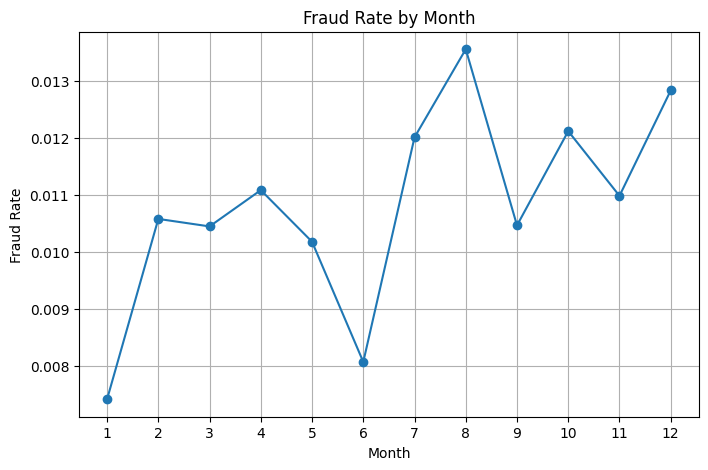

    tx_month      mean  count
0          1  0.007411  51542
1          2  0.010577  46516
2          3  0.010445  51219
3          4  0.011083  49537
4          5  0.010176  51885
5          6  0.008066  50336
6          7  0.012009  52209
7          8  0.013556  52374
8          9  0.010464  50174
9         10  0.012118  51659
10        11  0.010982  50537
11        12  0.012832  51667


In [28]:
# month별 fraud rate
month_stat = (
    df.groupby("tx_month")["fraud"]
      .agg(["mean", "count"])
      .reset_index()
      .sort_values("tx_month")
)

plt.figure(figsize=(8,5))
plt.plot(month_stat["tx_month"], month_stat["mean"], marker="o")
plt.title("Fraud Rate by Month")
plt.xlabel("Month")
plt.ylabel("Fraud Rate")
plt.xticks(range(1,13))
plt.grid(True)
plt.show()

print(month_stat)


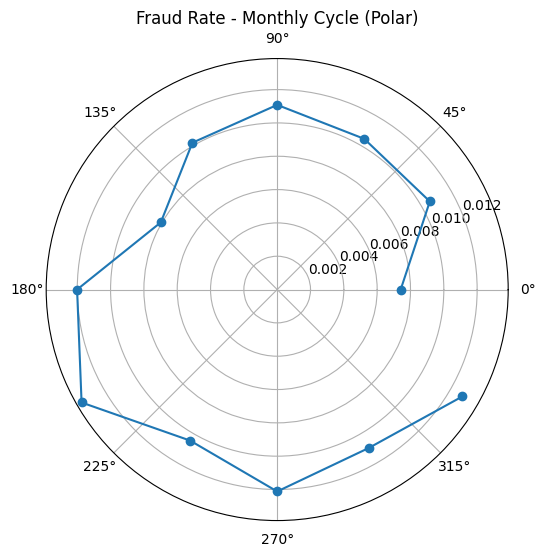

In [29]:
theta = 2 * np.pi * (month_stat["tx_month"] - 1) / 12

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, month_stat["mean"], marker="o")
ax.set_title("Fraud Rate - Monthly Cycle (Polar)")
plt.show()

> 최저: 1월 (~0.0074), 6월 (~0.0081)\
> 최고: 8월 (~0.0136), 12월 (~0.0128), 10월 (~0.0121)

Hour별 Fraud Rate 시각화

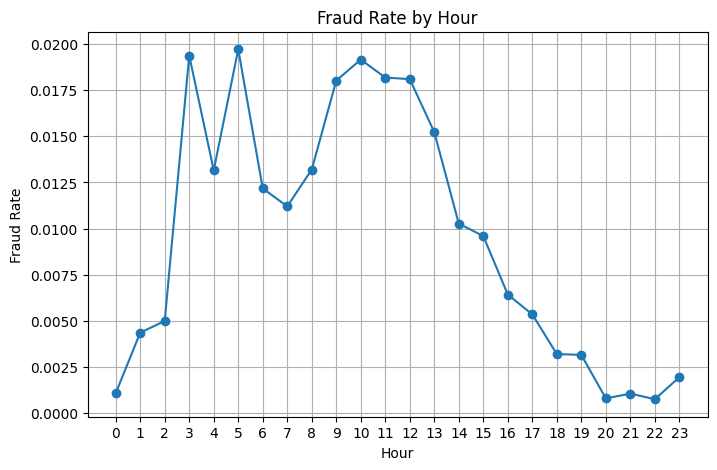

    tx_hour      mean  count
0         0  0.001065  11267
1         1  0.004350   8276
2         2  0.004985   7221
3         3  0.019382   4695
4         4  0.013156   9197
5         5  0.019727   9834
6         6  0.012177  32438
7         7  0.011200  39999
8         8  0.013199  32957
9         9  0.018025  38835
10       10  0.019165  36943
11       11  0.018191  38865
12       12  0.018103  32591
13       13  0.015231  37359
14       14  0.010266  46953
15       15  0.009592  44621
16       16  0.006417  50962
17       17  0.005344  23767
18       18  0.003190  18182
19       19  0.003144  21626
20       20  0.000783  19153
21       21  0.001044  18196
22       22  0.000740  14868
23       23  0.001935  10850


In [ ]:
hour_stat = (
    df.groupby("tx_hour")["fraud"]
      .agg(["mean", "count"])
      .reset_index()
      .sort_values("tx_hour")
)

plt.figure(figsize=(8,5))
plt.plot(hour_stat["tx_hour"], hour_stat["mean"], marker="o")
plt.title("Fraud Rate by Hour")
plt.xlabel("Hour")
plt.ylabel("Fraud Rate")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

print(hour_stat)


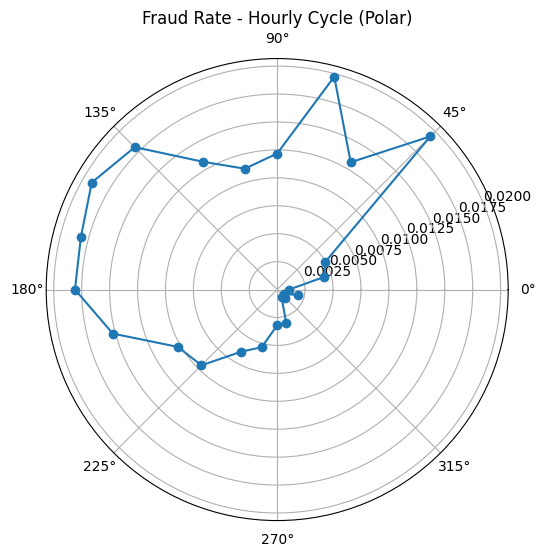

In [ ]:
theta = 2 * np.pi * hour_stat["tx_hour"] / 24

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, hour_stat["mean"], marker="o")
ax.set_title("Fraud Rate - Hourly Cycle (Polar)")
plt.show()

🔺 고위험 시간대

    03시 (~1.94%)
    05시 (~1.97%)
    09~12시 (1.8~1.9%)

🔻 저위험 시간대

    20~22시 (0.07~0.1%)
    0시 (0.1%)

---

## 1) 타깃/라벨

* `fraud` : 0/1

**분석 포인트**

* base rate
* 클래스 비율 변화(시간축 drift)

---

In [ ]:
# 전체 base rate
base_rate = df["fraud"].mean()

print(f"Overall Fraud Rate: {base_rate:.6f}")
print(df["fraud"].value_counts(normalize=True))


Overall Fraud Rate: 0.010823
fraud
0    0.989177
1    0.010823
Name: proportion, dtype: float64


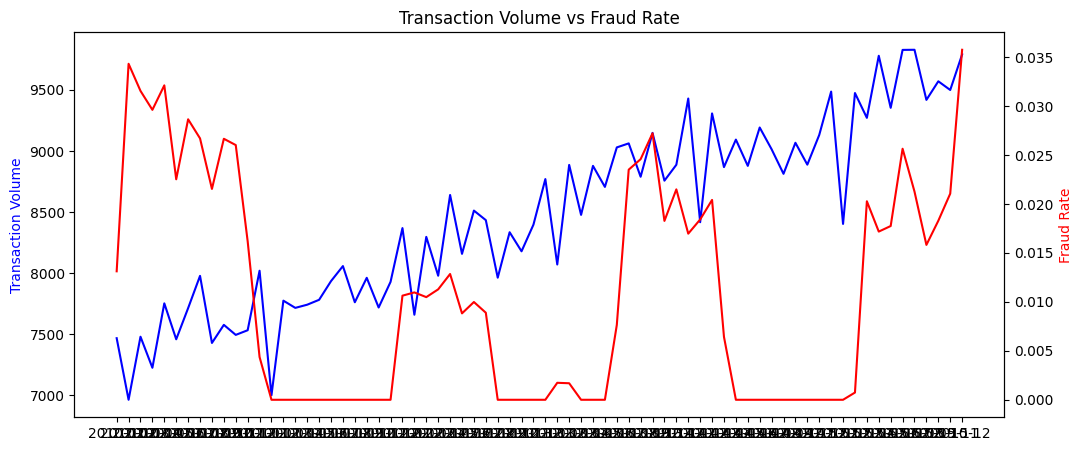

In [ ]:
monthly_full = (
    df.groupby(["tx_year", "tx_month"])["fraud"]
      .agg(["mean", "count"])
      .reset_index()
)

monthly_full["year_month"] = (
    monthly_full["tx_year"].astype(str) + "-" +
    monthly_full["tx_month"].astype(str).str.zfill(2)
)

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(monthly_full["year_month"], monthly_full["count"], color="blue")
ax1.set_ylabel("Transaction Volume", color="blue")

ax2 = ax1.twinx()
ax2.plot(monthly_full["year_month"], monthly_full["mean"], color="red")
ax2.set_ylabel("Fraud Rate", color="red")

plt.xticks(rotation=90)
plt.title("Transaction Volume vs Fraud Rate")
plt.show()


In [36]:
q_hi = monthly_full["mean"].quantile(0.75)
q_lo = monthly_full["mean"].quantile(0.25)

print("q_hi:", q_hi, "q_lo:", q_lo)
print("n_high_months:", (monthly_full["mean"] > q_hi).sum())
print("n_low_months :", (monthly_full["mean"] < q_lo).sum())
print("n_eq_qlo     :", (monthly_full["mean"] == q_lo).sum())


q_hi: 0.0205747681639434 q_lo: 0.0
n_high_months: 18
n_low_months : 0
n_eq_qlo     : 29


In [37]:
# 1) quantile
q_hi = monthly_full["mean"].quantile(0.75)
q_lo = monthly_full["mean"].quantile(0.25)

print("q_hi:", q_hi, "q_lo:", q_lo)

# 2) high/low 정의: 너가 말한대로 경계 포함
high_period = monthly_full[monthly_full["mean"] >= q_hi].copy()
low_period  = monthly_full[monthly_full["mean"] <= q_lo].copy()

print("n_high_months:", len(high_period))
print("n_low_months :", len(low_period))

# 3) key 만들기 (여기도 반드시 >=, <= 로)
high_keys = list(zip(high_period["tx_year"], high_period["tx_month"]))
low_keys  = list(zip(low_period["tx_year"],  low_period["tx_month"]))

# 4) df에 period_group 라벨링
df = df.copy()
df["period_group"] = "mid"

pairs = pd.MultiIndex.from_arrays([df["tx_year"], df["tx_month"]])

if len(high_keys) > 0:
    df.loc[pairs.isin(pd.MultiIndex.from_tuples(high_keys)), "period_group"] = "high"

if len(low_keys) > 0:
    df.loc[pairs.isin(pd.MultiIndex.from_tuples(low_keys)), "period_group"] = "low"

# 5) 분리
df_h = df[df["period_group"] == "high"].copy()
df_l = df[df["period_group"] == "low"].copy()

print(df_h.shape, df_l.shape)
print("high fraud rate:", df_h["fraud"].mean(), " low fraud rate:", df_l["fraud"].mean())


q_hi: 0.0205747681639434 q_lo: 0.0
n_high_months: 18
n_low_months : 29
(149905, 69) (243051, 69)
high fraud rate: 0.02653013575264334  low fraud rate: 0.0


In [38]:
EXCLUDE = {
    "fraud", "date", "period_group",
    "client_id", "card_id", "merchant_id"
}

feature_cols = [c for c in df.columns if c not in EXCLUDE]

# 수치형/이진형 분리
num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
bin_cols = [c for c in num_cols if df[c].dropna().isin([0, 1]).all()]
cont_cols = [c for c in num_cols if c not in bin_cols]

print("cont:", len(cont_cols), "bin:", len(bin_cols))

cont: 33 bin: 30


In [39]:
from scipy.stats import ks_2samp, mannwhitneyu

def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    if na < 2 or nb < 2:
        return np.nan
    sa, sb = a.std(ddof=1), b.std(ddof=1)
    pooled = np.sqrt(((na-1)*sa**2 + (nb-1)*sb**2) / (na+nb-2))
    return (a.mean() - b.mean()) / (pooled + 1e-12)

rows = []
for col in cont_cols:
    xh = df_h[col].dropna()
    xl = df_l[col].dropna()
    if len(xh) < 30 or len(xl) < 30:
        continue

    ks_p = ks_2samp(xh, xl).pvalue
    mw_p = mannwhitneyu(xh, xl, alternative="two-sided").pvalue
    d = cohens_d(xh, xl)

    rows.append({
        "feature": col,
        "type": "continuous",
        "high_mean": float(xh.mean()),
        "low_mean": float(xl.mean()),
        "delta_mean": float(xh.mean() - xl.mean()),
        "cohen_d": float(d),
        "KS_p": float(ks_p),
        "MW_p": float(mw_p),
        "n_high": int(len(xh)),
        "n_low": int(len(xl)),
    })

res_cont = pd.DataFrame(rows).set_index("feature").sort_values("MW_p")
res_cont.head(10)


,type,high_mean,low_mean,delta_mean,cohen_d,KS_p,MW_p,n_high,n_low
feature,,,,,,,,,
months_to_expire,continuous,106.809806,102.231519,4.578287,0.126375,0.000000e+00,0.000000e+00,149905,243051
tx_month,continuous,8.077062,7.105500,0.971562,0.303798,0.000000e+00,0.000000e+00,149905,243051
tx_year,continuous,2012.017131,2012.605918,-0.588787,-0.341671,0.000000e+00,0.000000e+00,149905,243051
years_since_pin_change,continuous,1.841600,2.105373,-0.263773,-0.123191,0.000000e+00,0.000000e+00,149905,243051
month_sin,continuous,-0.317486,-0.103360,-0.214126,-0.326308,0.000000e+00,0.000000e+00,149905,243051
months_from_account,continuous,67.098442,71.069364,-3.970922,-0.084569,9.899094e-236,1.304036e-205,149905,243051
client_prev_fraud_cnt,continuous,2.615056,2.862753,-0.247697,-0.051422,3.199158e-131,1.047847e-130,149905,243051
merchant_prev_fraud_cnt,continuous,12.285941,13.031282,-0.745340,-0.032461,0.000000e+00,3.751003e-64,149905,243051
credit_limit,continuous,16063.235352,16194.696289,-131.460938,-0.010725,6.893028e-11,4.229329e-07,149905,243051


In [41]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

rows = []
for col in bin_cols:
    xh = df_h[col].astype(int)
    xl = df_l[col].astype(int)

    a1 = int((xh == 1).sum()); a0 = int((xh == 0).sum())
    b1 = int((xl == 1).sum()); b0 = int((xl == 0).sum())

    n_high = a1 + a0
    n_low  = b1 + b0

    if n_high < 30 or n_low < 30:
        continue

    table = np.array([[a1, a0],
                      [b1, b0]], dtype=int)

    # rate
    high_rate = a1 / (n_high + 1e-12)
    low_rate  = b1 / (n_low  + 1e-12)

    # 0 cell이 있으면 Fisher로 (2x2에서 안정적)
    if (table == 0).any():
        # fisher_exact은 [[a1,a0],[b1,b0]] 형태 OK
        odds, p = fisher_exact(table, alternative="two-sided")
        test = "fisher"
        chi2 = np.nan
    else:
        chi2, p, _, _ = chi2_contingency(table, correction=False)
        odds = (a1 * b0) / (a0 * b1 + 1e-12)  # OR (안전)
        test = "chi2"

    rows.append({
        "feature": col,
        "type": "binary",
        "high_rate": float(high_rate),
        "low_rate": float(low_rate),
        "delta_rate": float(high_rate - low_rate),
        "p_value": float(p),
        "test": test,
        "odds_ratio": float(odds) if np.isfinite(odds) else np.nan,
        "a1_high": a1, "a0_high": a0,
        "b1_low": b1,  "b0_low": b0,
        "n_high": int(n_high),
        "n_low": int(n_low),
    })

res_bin = pd.DataFrame(rows).set_index("feature").sort_values("p_value")
res_bin.head(20)


,type,high_rate,low_rate,delta_rate,p_value,test,odds_ratio,a1_high,a0_high,b1_low,b0_low,n_high,n_low
feature,,,,,,,,,,,,,
mccg_Industrial_/_Manufacturing,binary,0.002755,0.000000,0.002755,9.893928e-174,fisher,NaN,413,149492,0,243051,149905,243051
mccg_Retail,binary,0.021620,0.016869,0.004751,1.187703e-26,chi2,1.287895,3241,146664,4100,238951,149905,243051
mccg_Food_Daily,binary,0.085267,0.077202,0.008065,1.592069e-19,chi2,1.114210,12782,137123,18764,224287,149905,243051
mccg_Transport_Travel,binary,0.626557,0.640327,-0.013770,3.051485e-18,chi2,0.942416,93924,55981,155632,87419,149905,243051
is_refund,binary,0.006658,0.005764,0.000893,4.793051e-04,chi2,1.156017,998,148907,1401,241650,149905,243051
has_chip,binary,0.915840,0.913491,0.002349,1.058767e-02,chi2,1.030549,137289,12616,222025,21026,149905,243051
err_insufficient_balance,binary,0.007371,0.008089,-0.000718,1.309787e-02,chi2,0.910639,1105,148800,1966,241085,149905,243051
is_prepaid,binary,0.076515,0.074454,0.002062,1.731859e-02,chi2,1.029984,11470,138435,18096,224955,149905,243051
is_weekend,binary,0.287335,0.283998,0.003337,2.441658e-02,chi2,1.016489,43073,106832,69026,174025,149905,243051


In [42]:
alpha = 0.05

sig_cont = res_cont[
    (res_cont["MW_p"] < alpha) &
    (res_cont["KS_p"] < alpha) &
    (res_cont["cohen_d"].abs() >= 0.10)
].sort_values("MW_p")

sig_cont.head(30)


,type,high_mean,low_mean,delta_mean,cohen_d,KS_p,MW_p,n_high,n_low
feature,,,,,,,,,
months_to_expire,continuous,106.809806,102.231519,4.578287,0.126375,0.0,0.0,149905,243051
tx_month,continuous,8.077062,7.105500,0.971562,0.303798,0.0,0.0,149905,243051
tx_year,continuous,2012.017131,2012.605918,-0.588787,-0.341671,0.0,0.0,149905,243051
years_since_pin_change,continuous,1.841600,2.105373,-0.263773,-0.123191,0.0,0.0,149905,243051
month_sin,continuous,-0.317486,-0.103360,-0.214126,-0.326308,0.0,0.0,149905,243051


In [44]:
alpha = 0.05
min_delta = 0.005 

sig_bin = res_bin[
    (res_bin["p_value"] < alpha) &
    (res_bin["delta_rate"].abs() >= min_delta)
].sort_values("p_value")

print("kept:", len(sig_bin))
sig_bin.head(30)


kept: 2


,type,high_rate,low_rate,delta_rate,p_value,test,odds_ratio,a1_high,a0_high,b1_low,b0_low,n_high,n_low
feature,,,,,,,,,,,,,
mccg_Food_Daily,binary,0.085267,0.077202,0.008065,1.592069e-19,chi2,1.114210,12782,137123,18764,224287,149905,243051
mccg_Transport_Travel,binary,0.626557,0.640327,-0.013770,3.051485e-18,chi2,0.942416,93924,55981,155632,87419,149905,243051


High fraud period는

> 특정 계절에 집중\
> PIN 변경 직후 기간과 연관\
> 카드 만료 기간과 약한 연관

-> sin, cos 넣은 것은 합리적


---

## 2) 거래 금액/결제 이벤트 핵심 (가장 직접적인 신호)

* `amount`
* `is_refund` (amount<0)
* `log_abs_amount`
* `amount_income_ratio`
* `amount_limit_ratio`

**분석 포인트**

* fraud vs non-fraud 분포(특히 long-tail)
* refund(음수) 케이스가 fraud와 실제로 연관 있는지
* ratio류(소득/한도 대비)가 “극단값”에서만 먹는지
* 금액 관련 파생끼리 상관/중복 여부

---


---

## 3) 고객 인구통계/신용 프로필 (customer risk profile)

* `current_age`
* `male`
* `yearly_income`, `log_yearly_income`
* `per_capita_income`
* `income_ratio_region`, `log_income_ratio_region`
* `total_debt`
* `credit_score`

**분석 포인트**

* fraud가 특정 구간(저신용/고부채/저소득)에서 증가하는지
* income 원천 변수와 파생 변수(로그/비율) 중복/효용 비교
* demographic 변수는 **편향/해석 이슈**가 생길 수 있으니 영향이 크면 사용 목적을 명확히(성능 vs 정책)

---

---

## 4) 카드/계정 상태(카드 생애주기 + 보안 이벤트)

* `num_cards_issued`
* `num_credit_cards`
* `credit_limit`
* `has_chip`
* `year_pin_last_changed`
* `years_since_pin_change`
* `months_to_expire`

**분석 포인트**

* PIN 변경 직후/오래된 PIN이 위험 신호인지
* 만료 임박(months_to_expire)이 fraud에 연결되는지
* chip 유무, 카드 발급 수가 어떤 의미인지(사기 시나리오 해석)
* “한도/소득/부채” 조합으로 risk profile 강화 가능

---


---

## 5) 거래 채널/거래 성격(온라인 vs 오프라인 + 결제 타입)

* `is_online`  ← 너가 말한 “온라인 결제 여부”
* `is_credit`
* `is_prepaid`

**분석 포인트**

* 채널별 base rate 차이(online/offline에 따라 사기 메커니즘 다름)
* prepaid가 사기/오류와 같이 움직이는지
* credit/prepaid 상호작용(온라인에서 특히 강해질 수 있음)

---


---

## 6) 거래 오류/거절 이벤트(Authorization 실패 신호)

* `has_error`
* `err_bad_card_number`
* `err_bad_expiration`
* `err_bad_cvv`
* `err_bad_pin`
* `err_bad_zipcode`
* `err_insufficient_balance`
* `err_technical_glitch`

**분석 포인트**

* fraud에서 error가 **선행 신호**인지(사도 시도→승인 패턴)
* error type 별로 fraud 상승이 있는지
* `has_error`와 개별 err_*는 중복(계층구조) → 어떤 레벨로 쓸지 결정

---


---

## 7) 시간 특성(시계열/행동 루틴)

* `tx_year`
* `tx_month`
* `tx_day`
* `tx_hour`
* `is_weekend`

**분석 포인트**

* fraud가 특정 시간대/요일/월에 몰리는지
* 연도별 drift (특히 너 데이터는 2017~2018 fraud=0 이슈 있었지)
* 단순 time feature 자체가 “연도 레이블”처럼 작동할 위험(데이터 생성/라벨링 편향)

---



---

## 8) 업종/상점 카테고리(MCC Group one-hot)

* `mccg_Food_Daily`
* `mccg_Transport_Travel`
* `mccg_Digital_Online`
* `mccg_Financial`
* `mccg_Retail`
* `mccg_Medical`
* `mccg_Entertainment`
* `mccg_Automotive_Home`
* `mccg_Utilities_Government`
* `mccg_Professional_Services`
* `mccg_Industrial_/_Manufacturing`

**분석 포인트**

* 어떤 카테고리에서 base rate가 높은지
* 온라인 결제(`is_online`)와 결합될 때 상승하는 카테고리(상호작용)
* one-hot 다중공선성(기준 카테고리 빠졌는지 확인)

---

---

## 9) 카드 브랜드(결제 네트워크)

* `cb_Visa`
* `cb_Mastercard`
* `cb_Amex`
* `cb_Discover`

**분석 포인트**

* 브랜드별 base rate 차이(실제 의미일 수도, 데이터 생성 특성일 수도)
* 브랜드와 금액/업종/온라인 간 상호작용 가능

---

---

## 10) 위치 기반(거래 위치 vs 거주지)

* `distance_from_home`

**분석 포인트**

* 거리 분포(0 근처 mass vs 장거리 tail)
* fraud에서 장거리/이상 이동이 증가하는지
* 금액/시간과 상호작용(야간 + 장거리 + 온라인/오프라인 등)

---

# 추천 “분석 순서” (실무스럽게, 누락 없이)

1. **라벨 분포 & 시간축 drift**: `fraud` × `tx_year/month`
2. **채널/오류 신호**: `is_online`, `has_error`, err_*
3. **금액/비율/로그**: amount 계열
4. **위치(distance)**
5. **업종/브랜드**
6. **신용/소득/부채/한도/계정상태**
7. 마지막으로 **ID 기반 집계 가능성(고객/카드/가맹점)** 정리

---
